# Week 4 - Alternate Attitude Control Formulations

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_shadow
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


## Functions from module 3

In [3]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next

In [4]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [5]:
def mrp_compose(s1, s2, mode="add"):
    """
    mrp_compose(s1, s2, mode)

    Q = mrp_compose(s1, s2, mode) provides the MRP vector corresponding to:

        mode = "add" :
            successive rotations s1 followed by s2

        mode = "sub" :
            relative rotation from s2 to s1

    This is a unified implementation of addMRP and subMRP.
    """

    # Ensure column-like vectors (but works with 1D arrays)
    s1 = np.asarray(s1, dtype=float).reshape(3,)
    s2 = np.asarray(s2, dtype=float).reshape(3,)

    s1_sq = np.dot(s1, s1)
    s2_sq = np.dot(s2, s2)
    s1_dot_s2 = np.dot(s1, s2)
    s1_cross_s2 = np.cross(s1, s2)

    if mode == "add":
        # --- MRP addition (successive rotations) ---
        q = ((1 - s1_sq) * s2 + (1 - s2_sq) * s1 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq - 2 * s1_dot_s2)

    elif mode == "sub":
        # --- MRP subtraction (relative attitude) ---
        q = ((1 - s2_sq) * s1 - (1 - s1_sq) * s2 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq + 2 * s1_dot_s2)

    else:
        raise ValueError("mode must be 'add' or 'sub'")

    return mrp_shadow(q)

In [6]:
def cc_xdot_mrp(
    t: float,
    x: np.ndarray,
    u_B: np.ndarray,
    ctx: dict,
) -> np.ndarray:
    """
    Rigid-body MRP attitude dynamics (plant model only).

    This function defines the continuous-time plant dynamics:

        x_dot = f(t, x, u)

    where the state is:
        x = [ sigma_BN (3), omega_BN_B (3) ]

    and the control input is:
        u_B = body control torque expressed in frame B.

    No controller logic is included here. This function represents
    the physical spacecraft rotational dynamics only.

    Parameters
    ----------
    t : float
        Current simulation time [s]. (Not explicitly used here but
        included for compatibility with generic integrators.)

    x : np.ndarray, shape (6,)
        State vector:
            x[0:3] = sigma_BN     (MRPs of body B relative to inertial N)
            x[3:6] = omega_BN_B   (angular rate of B wrt N, expressed in B) [rad/s]

    u_B : np.ndarray, shape (3,)
        Control torque applied in body frame B [N*m].

    ctx : dict
        Context dictionary containing spacecraft parameters under
        the "sc" namespace:
            ctx["sc"]["I"]   : inertia matrix in body frame B (3x3)
            ctx["sc"]["L_B"] : external disturbance torque applied
                            to the plant (3,) [N*m] (default zero)

    Returns
    -------
    xdot : np.ndarray, shape (6,)
        Time derivative of the state vector:
            xdot[0:3] = sigma_dot   (MRP kinematics)
            xdot[3:6] = omega_dot_B (rigid-body rotational dynamics)
    """
    x = np.asarray(x, dtype=float).reshape(-1,)
    if x.size != 6:
        raise ValueError(f"cc_xdot expects state length 6, got {x.size}")

    # ---- unpack state ----
    sigma_BN = ak.MRP_shadow(x[0:3])
    omega_BN_B = x[3:6]

    # ---- input torque ----
    u_B = np.asarray(u_B, dtype=float).reshape(3,)

    # ---- plant parameters (spacecraft truth only) ----
    sc = ctx["sc"]
    I = np.asarray(sc["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(sc.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    # ---- rigid-body rotational dynamics ----
    # I * omega_dot = u + L - omega x (I omega)
    omega_dot_B = np.linalg.solve(I, u_B + L_B - np.cross(omega_BN_B, I @ omega_BN_B))

    # ---- MRP kinematics ----
    # sigma_dot = 0.25 * B(sigma) * omega
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)
    
    # Pack state derivative
    xdot = np.hstack((sigma_dot, omega_dot_B))
    
    return xdot

In [7]:
def simulate_CC(
    controller=None,
    plant=cc_xdot_mrp,
    spacecraft_params: dict | None = None,
    controller_params: dict | None = None,
    simulation_config: dict | None = None,
    reference_config: dict | None = None,
    grading_config: dict | None = None,
):
    """
    RK4 simulator harness for Coursera attitude concept checks.

    This simulator integrates the 6-state rigid-body attitude dynamics:
        x = [sigma_BN (MRP), omega_BN_B]

    using a fixed-step RK4 integrator.

    ZOH semantics (grading-critical):
    - The controller is evaluated once per outer step at time t_k.
    - The resulting u_B is held constant during the RK4 sub-stages for that step.
    - This is implemented by passing u_B into the plant as a constant input for the RK4 step.

    Parameters
    ----------
    controller : callable
        Control law with signature:
            u_B = controller(t, state, ref_k, ctx)

        where:
            state : dict with keys {"sigma_BN", "omega_BN_B"}
            ref_k : dict with keys {"sigma_RN", "omega_RN_R", "omega_dot_RN_R"}
            ctx   : dict with namespaces:
                    ctx["sc"]  spacecraft parameters (truth)
                    ctx["ctl"] controller parameters + memory

    plant : callable
        Plant state derivative with signature:
            xdot = plant(t, x, u_B, ctx)

        Note:
        - plant is purely physics. It does not call the controller.
        - plant should read only spacecraft truth parameters from ctx["sc"].

    spacecraft_params : dict
        Spacecraft physical parameters (truth).
        Typical keys:
            "I"   (3x3): inertia matrix in B
            "L_B" (3,): external disturbance torque applied to the plant

    controller_params : dict
        Controller parameters and controller memory.
        Typical keys:
            "K", "P", "Ki"
            "modelL_B" (3,)  (optional model estimate; not used by all controllers)
            "integral_sigma_BR" (3,) (controller memory)
            "omega_BR0_B" (3,)       (controller memory / initialization)

    simulation_config : dict
        Simulation setup:
            {"t0": float, "tf": float, "dt": float,
             "sigma0": (3,), "omega0_deg": (3,), "eta0": (3,) optional}

    reference_config : dict
        Reference generation configuration:
            {"mode": "tracking"|"regulator", "f": float}

        For tracking mode, this function generates sigma_RN(t) as in the concept checks.

    grading_config : dict
        Coursera helper for printing a norm at a chosen time:
            {"time_s": float, "quantity": "sigma_BR"|"sigma_BN"}

    Returns
    -------
    results : dict
        Time histories and key logged quantities.
    """
    # ---- Default dictionaries ----
    if spacecraft_params is None:
        spacecraft_params = {}
    if controller_params is None:
        controller_params = {}
    if simulation_config is None:
        simulation_config = {}
    if reference_config is None:
        reference_config = {}
    if grading_config is None:
        grading_config = {}

    spacecraft_params = dict(spacecraft_params)
    controller_params = dict(controller_params)
    simulation_config = dict(simulation_config)
    reference_config = dict(reference_config)
    grading_config = dict(grading_config)

    # ---- Time setup ----
    t0 = float(simulation_config.get("t0", 0.0))
    tf = float(simulation_config.get("tf", 120.0))
    dt = float(simulation_config.get("dt", 0.01))

    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    # ---- Spacecraft parameters ----
    if "I" not in spacecraft_params:
        spacecraft_params["I"] = np.diag([100.0, 75.0, 80.0])
    spacecraft_params["I"] = np.asarray(spacecraft_params["I"], dtype=float).reshape(3, 3)

    spacecraft_params.setdefault("L_B", np.zeros(3))
    spacecraft_params["L_B"] = np.asarray(spacecraft_params["L_B"], dtype=float).reshape(3,)

    # ---- Controller parameters ----
    controller_params.setdefault("K", 5.0)
    controller_params.setdefault("P", 10.0)
    controller_params.setdefault("Ki", 0.0)
    controller_params.setdefault("modelL_B", np.zeros(3))
    controller_params["modelL_B"] = np.asarray(controller_params["modelL_B"], dtype=float).reshape(3,)

    # ---- Initial conditions ----
    sigma0 = np.asarray(simulation_config.get("sigma0", [0.1, 0.2, -0.1]), dtype=float).reshape(3,)
    omega0_deg = np.asarray(simulation_config.get("omega0_deg", [30.0, 10.0, -20.0]), dtype=float).reshape(3,)
    omega0 = np.deg2rad(omega0_deg)

    x = np.hstack((sigma0, omega0))
    x[0:3] = mrp_shadow(x[0:3])

    # ---- Integral memory ----
    eta0 = simulation_config.get("eta0", None)
    if eta0 is None:
        controller_params.setdefault("integral_sigma_BR", np.zeros(3))
    else:
        controller_params["integral_sigma_BR"] = np.asarray(eta0, dtype=float).reshape(3,)

    # ---- Reference generation ----
    ref_mode = str(reference_config.get("mode", "tracking")).lower()
    f = float(reference_config.get("f", 0.05))

    sigma_RN_hist = np.zeros((N, 3))
    omega_RN_R_hist = np.zeros((N, 3))
    omega_dot_RN_R_hist = np.zeros((N, 3))

    if ref_mode == "tracking":
        for k, tt in enumerate(t_hist):
            st = np.sin(f * tt)
            ct = np.cos(f * tt)

            sigma_RN = np.array([0.2 * st, 0.3 * ct, -0.3 * st])
            sigma_RN_dot = np.array([0.2 * f * ct, -0.3 * f * st, -0.3 * f * ct])

            sigma_RN_hist[k] = sigma_RN
            omega_RN_R_hist[k] = 4.0 * ak.BInvmat_MRP(sigma_RN) @ sigma_RN_dot

        omega_dot_RN_R_hist[:] = np.gradient(omega_RN_R_hist, t_hist, axis=0)

    elif ref_mode == "regulator":
        # Leave reference histories as zeros
        pass
    else:
        raise ValueError("reference_config['mode'] must be 'tracking' or 'regulator'")

    # ---- Grading setup ----
    report_time_s = float(grading_config.get("time_s", 40.0))
    report_quantity = str(grading_config.get("quantity", "sigma_BR"))

    # ---- Initialize omega_BR0_B if needed ----
    if "omega_BR0_B" not in controller_params:
        sigma_BN0 = x[0:3]
        omega_BN_B0 = x[3:6]

        sigma_RN0 = sigma_RN_hist[0]
        omega_RN_R0 = omega_RN_R_hist[0]

        C_BN0 = ak.MRP_to_DCM(sigma_BN0)
        C_RN0 = ak.MRP_to_DCM(sigma_RN0)
        C_BR0 = C_BN0 @ C_RN0.T

        omega_RN_B0 = C_BR0 @ omega_RN_R0
        controller_params["omega_BR0_B"] = omega_BN_B0 - omega_RN_B0

    # ---- Storage ----
    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))

    sigma_BN_hist = np.zeros((N, 3))
    omega_BN_B_hist = np.zeros((N, 3))

    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))
    sigma_norm_hist = np.zeros(N)
    z_hist = np.zeros((N, 3))

    # ---- Namespaced context ----
    ctx = {
        "sc": spacecraft_params,
        "ctl": controller_params,
    }

    # ---- Simulation loop ----
    for k, tt in enumerate(t_hist):
        # Progress reporting every 30 seconds
        if k == 0:
            next_report_t = 30.0
        if tt >= next_report_t:
            print(f"simulate_CC: simulated up to t = {next_report_t:.0f} s")
            next_report_t += 30.0

        sigma_BN = x[0:3]
        omega_BN_B = x[3:6]

        sigma_BN_hist[k] = sigma_BN
        omega_BN_B_hist[k] = omega_BN_B

        state = {
            "sigma_BN": sigma_BN,
            "omega_BN_B": omega_BN_B,
        }

        ref_k = {
            "sigma_RN": sigma_RN_hist[k],
            "omega_RN_R": omega_RN_R_hist[k],
            "omega_dot_RN_R": omega_dot_RN_R_hist[k],
        }

        # ---- Compute tracking errors (in B) ----
        C_BN = ak.MRP_to_DCM(sigma_BN)
        C_RN = ak.MRP_to_DCM(ref_k["sigma_RN"])
        C_BR = C_BN @ C_RN.T

        sigma_BR = ak.DCM_to_MRP(C_BR)
        omega_BR_B = omega_BN_B - C_BR @ ref_k["omega_RN_R"]

        # ---- Update integral state (single owner: ctx["ctl"]) ----
        ctx["ctl"]["integral_sigma_BR"] += dt * sigma_BR

        # ---- Log z quantity ----
        eta = ctx["ctl"]["integral_sigma_BR"]
        omega_BR0_B = ctx["ctl"]["omega_BR0_B"]
        z = ctx["ctl"]["K"] * eta + ctx["sc"]["I"] @ (omega_BR_B - omega_BR0_B)
        z_hist[k] = z

        # ---- Store error histories ----
        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B
        sigma_norm_hist[k] = (
            np.linalg.norm(sigma_BN)
            if report_quantity == "sigma_BN"
            else np.linalg.norm(sigma_BR)
        )

        # ---- Sample controller once per step (ZOH) ----
        u_B = controller(tt, state, ref_k, ctx)
        u_hist[k] = u_B

        x_hist[k] = x

        # ---- Integrate plant with held control ----
        if k < N - 1:
            x_next = rk4_step(
                plant,
                tt,
                x,
                dt,
                u_B,
                ctx,
            )
            x_next[0:3] = mrp_shadow(x_next[0:3])
            x = x_next

    # ---- Grading output ----
    idx = np.argmin(np.abs(t_hist - report_time_s))
    label = "sigma_BN" if report_quantity == "sigma_BN" else "sigma_BR"
    print(f"CC: norm({label}) at t={t_hist[idx]:.3f} s = {sigma_norm_hist[idx]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "sigma_BN": sigma_BN_hist,
        "omega_BN_B": omega_BN_B_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR_B": omega_BR_hist,
        "z": z_hist,
        "u": u_hist,
        "sigma_norm": sigma_norm_hist,
        "params": {
            "spacecraft_params": spacecraft_params,
            "controller_params": controller_params,
        },
        "meta": {
            "simulation_config": {"t0": t0, "tf": tf, "dt": dt},
            "reference_config": {"mode": ref_mode, "f": f},
            "grading_config": {"time_s": report_time_s, "quantity": report_quantity},
        },
    }
    return results

## CC1

In [8]:
def cc1_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC1 tracking controller with torque saturation.

    Control law (model disturbance optional):
        u = -K*sigma_BR - P*omega_BR_B
            + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
            + cross(omega_BN_B, I*omega_BN_B)
            - modelL_B

    Saturation (magnitude clamp):
        if norm(u) <= u_max: u_sat = u
        else:                u_sat = u_max * u / norm(u)

    State
    -----
    state["sigma_BN"]   : MRPs of B relative N
    state["omega_BN_B"] : angular rate of B relative N expressed in B

    Reference
    ---------
    ref["sigma_RN"]       : MRPs of R relative N
    ref["omega_RN_R"]     : angular rate of R relative N expressed in R
    ref["omega_dot_RN_R"] : angular accel of R relative N expressed in R

    Context
    -------
    ctx["sc"]["I"]       : inertia matrix in B
    ctx["ctl"]["K"]      : attitude gain
    ctx["ctl"]["P"]      : rate gain, scalar or (3,) or (3,3)
    ctx["ctl"]["u_max"]  : saturation limit on norm(u), default inf
    ctx["ctl"]["modelL_B"]: modeled disturbance torque in B, default zeros

    Returns
    -------
    u_B : control torque in B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = np.asarray(ctx["ctl"]["P"], dtype=float)
    u_max = float(ctx["ctl"].get("u_max", np.inf))
    modelL_B = np.asarray(ctx["ctl"].get("modelL_B", np.zeros(3)), dtype=float).reshape(3,)

    # Make P behave like a diagonal gain matrix
    if P.ndim == 0:
        P_mat = float(P) * np.eye(3)
    elif P.shape == (3,):
        P_mat = np.diag(P)
    elif P.shape == (3, 3):
        P_mat = P
    else:
        raise ValueError("ctx['ctl']['P'] must be scalar, (3,), or (3,3)")

    # 1) attitude and rate error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # 2) feedforward term
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    ff = I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))

    # 3) unsaturated control
    u_unsat = (
        -K * sigma_BR
        -P_mat @ omega_BR_B
        + ff
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - modelL_B
    )

    # 4) magnitude saturation on norm(u)
    u_B = np.clip(u_unsat, -u_max, u_max)

    # Optional debug logging for the simulator (controller memory only)
    ctx["is_saturated_last"] = np.any(np.abs(u_unsat) >= u_max)
    ctx["u_unsat_last"] = u_unsat
    ctx["u_last"] = u_B

    return u_B

In [9]:
# Given (from question)
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.zeros(3)

u_max = 1.0  # [N*m] saturation limit (torque magnitude)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
    "u_max": u_max,         # used by cc1_controller_u for saturation
    "modelL_B": np.zeros(3, dtype=float),
}

simulation_config = {
    "t0": 0.0,
    "tf": 180.0,            # 3 minutes
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 60.0,
    "quantity": "sigma_BR",
}

cc_sat_sim_results = simulate_CC(
    controller=cc1_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)

cc_sat_sim_results

simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
simulate_CC: simulated up to t = 150 s
simulate_CC: simulated up to t = 180 s
CC: norm(sigma_BR) at t=60.000 s = 0.520354142625876


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.7998e+02, 1.7999e+02,
        1.8000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10103031,  0.20044511, -0.10131765,  0.52352925,  0.17488666,
         -0.348655  ],
        [ 0.10206176,  0.20089031, -0.10263514,  0.52345975,  0.17523976,
         -0.34824361],
        ...,
        [ 0.08319244, -0.27348757, -0.12336054,  0.00196753, -0.01700525,
          0.06158517],
        [ 0.08310101, -0.27354896, -0.12322415,  0.00196156, -0.01698653,
          0.0615955 ],
        [ 0.08300956, -0.27361027, -0.12308774,  0.00195559, -0.01696781,
          0.06160582]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10103031,  0.20044511, -0.10131765],
        [ 0.10206176,  0.20089031, -0.10263514],
        ...,
        [ 0.08319244, -0.27348757, -0.12336054],
        [ 0.08310101, -0.27354896, -0.12322415],
        [ 0.08300956, -0.273

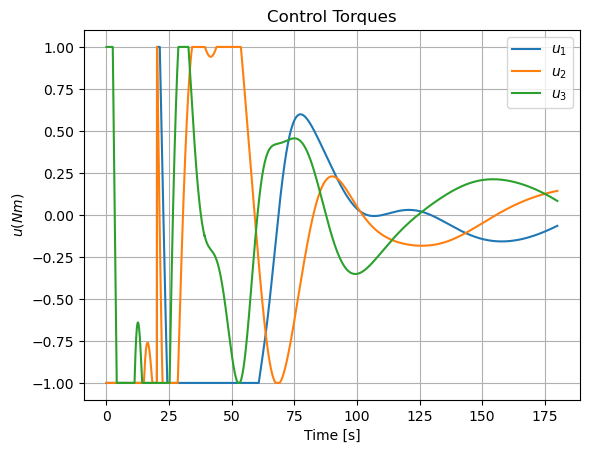

In [10]:
t = cc_sat_sim_results['t']
x = cc_sat_sim_results['x']
u = cc_sat_sim_results['u']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$u (Nm)$")
plt.title("Control Torques")
plt.legend()
plt.show()

## CC2

In [11]:
def cc2_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2 "Linear MRP CLD" regulation controller (linear closed-loop MRP dynamics).

    This implements the MRP feedback law on angular acceleration that yields:
        sigma_ddot + P*sigma_dot + K*sigma = 0

    Commanded body angular acceleration:
        omega_dot_cmd = -P*omega
                        - (omega*omega^T + alpha*I3) * sigma

    where
        alpha = 4K/(1 + sigma^T*sigma) - 0.5*(omega^T*omega)

    Torque realization:
        u = I*omega_dot_cmd + omega x (I*omega) - modelL_B

    This is a regulation law about sigma=0 and omega=0. The ref input is ignored.

    State
    -----
    state["sigma_BN"]   : MRPs of B relative N
    state["omega_BN_B"] : angular rate of B relative N expressed in B

    Context
    -------
    ctx["sc"]["I"]        : inertia matrix in body frame B
    ctx["ctl"]["K"]       : attitude gain
    ctx["ctl"]["P"]       : rate gain (scalar)
    ctx["ctl"]["u_max"]   : component-wise saturation limit, default inf
    ctx["ctl"]["modelL_B"]: modeled disturbance torque in B, default zeros

    Returns
    -------
    u_B : (3,) control torque in body frame B
    """
    sigma = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])
    u_max = float(ctx["ctl"].get("u_max", np.inf))
    modelL_B = np.asarray(ctx["ctl"].get("modelL_B", np.zeros(3)), dtype=float).reshape(3,)

    # 1) slide terms
    sig2 = float(sigma @ sigma)
    w2 = float(omega @ omega)
    wwT = np.outer(omega, omega)
    alpha = (4.0 * K / (1.0 + sig2)) - 0.5 * w2

    omega_dot_cmd = -P * omega - (wwT + alpha * np.eye(3)) @ sigma

    # 2) torque realization
    u_unsat = I @ omega_dot_cmd + np.cross(omega, I @ omega) - modelL_B

    # 3) component-wise saturation 
    u_B = u_unsat.copy()
    if np.isfinite(u_max):
        u_B = np.clip(u_B, -u_max, u_max)

    # 4) debug hooks
    ctx["ctl"]["is_saturated_last"] = bool(np.any(np.abs(u_unsat) > u_max)) if np.isfinite(u_max) else False
    ctx["ctl"]["u_unsat_last"] = u_unsat
    ctx["ctl"]["u_last"] = u_B

    return u_B


In [12]:

I = np.diag([100.0, 75.0, 80.0])
K = 0.11
P = 3.0
L = np.zeros(3)

u_max = 1.0  # [N*m] saturation limit

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg_v1 = np.array([3.0, 1.0, -2.0])
omega0_deg_v2 = np.array([30.0, 10.0, -20.0])


spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P, 
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,           
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg_v2,
}

reference_config = {
    "mode": "regulator",
    "f": 0.05,
}

grading_config = {
    "time_s": 50.0,
    "quantity": "sigma_BR",
}

cc2_sat_sim_results = simulate_CC(
    controller=cc2_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)

cc2_sat_sim_results


simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BR) at t=50.000 s = 0.046075563045258


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01013731e-01,  2.00437281e-01, -1.01297402e-01,
          5.07048269e-01,  1.68664696e-01, -3.37974757e-01],
        [ 1.01995893e-01,  2.00859236e-01, -1.02554757e-01,
          4.91014046e-01,  1.62958406e-01, -3.27223342e-01],
        ...,
        [ 1.57993245e-03,  2.52872375e-03, -1.69288826e-03,
         -2.34623713e-04, -3.75521470e-04,  2.51397913e-04],
        [ 1.57934600e-03,  2.52778511e-03, -1.69225987e-03,
         -2.34536625e-04, -3.75382082e-04,  2.51304599e-04],
        [ 1.57875976e-03,  2.52684682e-03, -1.69163172e-03,
         -2.34449569e-04, -3.75242747e-04,  2.51211319e-04]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10101373,  0.20043728, -0.1012974 ],
        [ 0.10199589,  0.20085924, -0.102554

5000


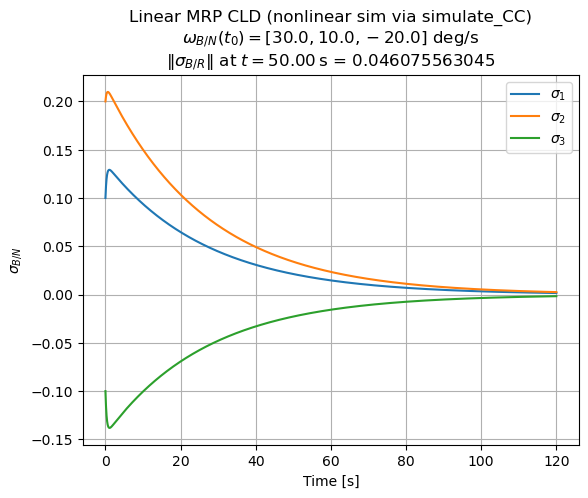

In [13]:
# --- unpack results (CC2 run) ---
t = cc2_sat_sim_results["t"]
sigma = cc2_sat_sim_results["x"][:, 0:3]
sigma_norm = cc2_sat_sim_results["sigma_norm"]

u = cc2_sat_sim_results["u"]          # <-- control torque history (N,3)
u_norm = np.linalg.norm(u, axis=1) 

omega = cc2_sat_sim_results["omega_BN_B"]

# Extract initial omega from simulation results
omega0_rad = omega[0]
omega0_deg = np.rad2deg(omega0_rad)


t_report = 50.0
idx = np.argmin(np.abs(t - t_report))
print(idx)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$\sigma_{B/N}$")
plt.title(
    "Linear MRP CLD (nonlinear sim via simulate_CC)\n"
    + rf"$\omega_{{B/N}}(t_0) = {np.round(omega0_deg, 3).tolist()}\ \mathrm{{deg/s}}$" + "\n"
    + rf"$\|\sigma_{{B/R}}\|$ at $t = {t[idx]:.2f}\,\mathrm{{s}}$ = {sigma_norm[idx]:.12f}"
)
plt.legend()
plt.show()


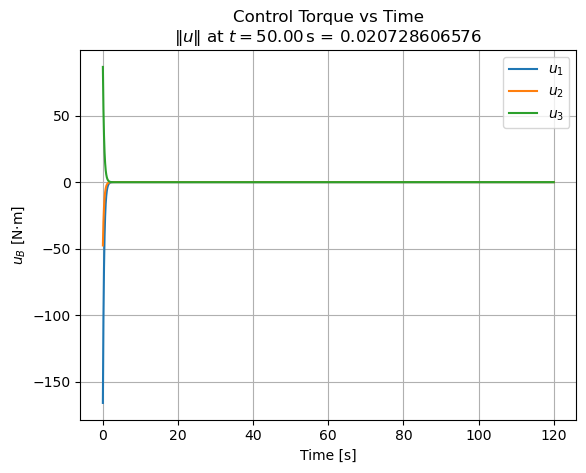

In [14]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$u_B$ [N·m]")   # or just "Torque" if units not specified in CC
plt.title(
    "Control Torque vs Time\n"
    + rf"$\|u\|$ at $t = {t[idx]:.2f}\,\mathrm{{s}}$ = {u_norm[idx]:.12f}"
)
plt.legend()
plt.show()

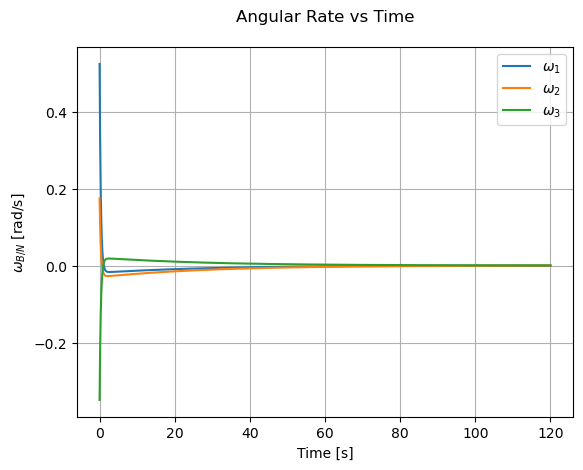

In [15]:
plt.figure()
plt.plot(t, omega[:, 0], label=r'$\omega_1$')
plt.plot(t, omega[:, 1], label=r'$\omega_2$')
plt.plot(t, omega[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$\omega_{B/N}$ [rad/s]")
plt.title(
    "Angular Rate vs Time\n"
)
plt.legend()
plt.show()

## CC3

In [16]:
# Wheel axes (columns of Gs), components expressed in body frame B
gs1 = np.array([ 0.267261, 0.534522, 0.801784])
gs2 = np.array([-0.267261, 0.534522, 0.801784])
gs3 = np.array([ 0.534522, 0.267261, 0.801784])
gs4 = np.array([-0.666667, 0.666667, 0.333333])

Gs = np.column_stack([gs1, gs2, gs3, gs4])
print(Gs)

Lr = np.array([0.1, 0.2, 0.4])    # Nm

u_s = Gs.T @ np.linalg.inv(Gs @ Gs.T) @ Lr

print("u_s [Nm] =", u_s.tolist())
print("Check Gs@u_s =", (Gs @ u_s).tolist())
print("||u_s|| =", float(np.linalg.norm(u_s)))

[[ 0.267261 -0.267261  0.534522 -0.666667]
 [ 0.534522  0.534522  0.267261  0.666667]
 [ 0.801784  0.801784  0.801784  0.333333]]
u_s [Nm] = [0.11048297033971265, 0.2077050376012058, 0.19444809448164532, -0.033070307304629704]
Check Gs@u_s = [0.0999999999999997, 0.19999999999999907, 0.39999999999999875]
||u_s|| = 0.3070041954970154
